Demonstrates Roq's new simulator

In [1]:
import os
import datetime

import matplotlib as mpl

import pandas as pd

import roq

This is the configuration

In [2]:
SETTINGS = roq.client.Settings2(
    app={
        "name": "trader",
    },
    loop={
        "timer_freq": datetime.timedelta(milliseconds=100),
    },
    service={},
    common={},
)


CONFIG = roq.algo.strategy.Config(
    legs=[
        roq.algo.Leg(
            source=0,
            account="A1",
            exchange="deribit",
            symbol="BTC-PERPETUAL",
            time_in_force=roq.TimeInForce.GTC,
        ),
        roq.algo.Leg(
            source=1,
            account="A1",
            exchange="bybit",
            symbol="BTCUSD",
        ),
    ],
    strategy_id=123,
)


def create_strategy(dispatcher, order_cache, config):
    return roq.algo.strategy.create(
        type=roq.algo.strategy.Type.ARBITRAGE,
        dispatcher=dispatcher,
        order_cache=order_cache,
        config=config,
        parameters="max_age=10s;threshold=5;quantity_0=1;min_position_0=-5;max_position_0=5",
    )


def create_reporter():
    return roq.algo.reporter.create(
        type=roq.algo.reporter.Type.SUMMARY,
    )


def create_matcher(dispatcher, order_cache, config):
    return roq.algo.matcher.create(
        type=roq.algo.matcher.Type.SIMPLE,
        dispatcher=dispatcher,
        order_cache=order_cache,
        config=config,
    )


FACTORY = roq.algo.Factory(
    create_strategy=create_strategy,
    create_reporter=create_reporter,
    create_matcher=create_matcher,
)


PARAMETERS = [
    "{HOME}/var/lib/roq/data/deribit-public.roq".format(**os.environ),
    "{HOME}/var/lib/roq/data/bybit-public.roq".format(**os.environ),
]

Now we launch the simulator

The simulator will create an instance of a reporter to collect data during the simulation run

The simulator will create a single strategy and manage the life-time of it (to avoid inadverently re-using state on subsequent simulation runs)

The simulator will dynamically create matching engines as they are needed

All this is done through factory methods allowing you to potentially use your own C++ bindings

In [8]:
# %%timeit -n 1 -r 1
reporter = roq.client.Simulator2.dispatch(
    settings=SETTINGS,
    factory=FACTORY,
    config=CONFIG,
    parameters=PARAMETERS,
)

17.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
L0 simple.cpp:100] [0:deribit] connected
L0 simple.cpp:100] [1:bybit] connected
L0 simple.cpp:127] [0:deribit] ready
L0 simple.cpp:127] [1:bybit] ready
L0 simple.cpp:106] [0:deribit] disconnected
L0 simple.cpp:106] [1:bybit] disconnected


The reporter may hold collected data (depending on the "type")

Here we extract some "history"

In [4]:
result = reporter.extract("history")
# print(result)

The result now holds data and index information, enough to create a Pandas DataFrame

In [5]:
df = pd.DataFrame(result["data"]).set_index(result["index"])
df

best_bid_price  \
source exchange symbol        sample_period_utc                     
0      deribit  BTC-PERPETUAL 1730473620000000000         71145.5   
                              1730473680000000000         71107.5   
                              1730473740000000000         70975.0   
                              1730473800000000000         70941.5   
                              1730473860000000000         70938.0   
...                                                           ...   
1      bybit    BTCUSD        1730484180000000000         69531.5   
                              1730484240000000000         69527.5   
                              1730484300000000000         69541.5   
                              1730484360000000000         69528.0   
                              1730484420000000000         69532.0   

                                                   best_ask_price  buy_volume  \
source exchange symbol        sample_period_utc                                 
0      deribit  BTC-PERPETUAL 1730473620000000000         71146.0         0.0   
                              1730473680000000000         71108.0        17.0   
                              1730473740000000000         70975.5        22.0   
                              1730473800000000000         70942.0        42.0   
                              1730473860000000000         70938.5        58.0   
...                                                           ...         ...   
1      bybit    BTCUSD        1730484180000000000         69532.0      4702.0   
                              1730484240000000000         69528.0      4702.0   
                              1730484300000000000         69542.0      4733.0   
                              1730484360000000000         69528.5      4758.0   
                              1730484420000000000         69532.5      4758.0   

                                                   sell_volume  position  \
source exchange symbol        sample_period_utc                            
0      deribit  BTC-PERPETUAL 1730473620000000000          6.0      -6.0   
                              1730473680000000000         23.0      -6.0   
                              1730473740000000000         28.0      -6.0   
                              1730473800000000000         48.0      -6.0   
                              1730473860000000000         64.0      -6.0   
...                                                        ...       ...   
1      bybit    BTCUSD        1730484180000000000       4701.0       1.0   
                              1730484240000000000       4706.0      -4.0   
                              1730484300000000000       4727.0       6.0   
                              1730484360000000000       4752.0       6.0   
                              1730484420000000000       4762.0      -4.0   

                                                   average_price  mark_price  \
source exchange symbol        sample_period_utc                                
0      deribit  BTC-PERPETUAL 1730473620000000000   71142.000000     71146.0   
                              1730473680000000000   71144.000000     71108.0   
                              1730473740000000000   71142.250000     70975.5   
                              1730473800000000000   70938.500000     70942.0   
                              1730473860000000000   70955.083333     70938.5   
...                                                          ...         ...   
1      bybit    BTCUSD        1730484180000000000   69525.000000     69531.5   
                              1730484240000000000   69535.000000     69528.0   
                              1730484300000000000   69533.000000     69541.5   
                              1730484360000000000   69536.500000     69528.0   
                              1730484420000000000   69543.000000     69532.5   

                                                   unrealized_profit 

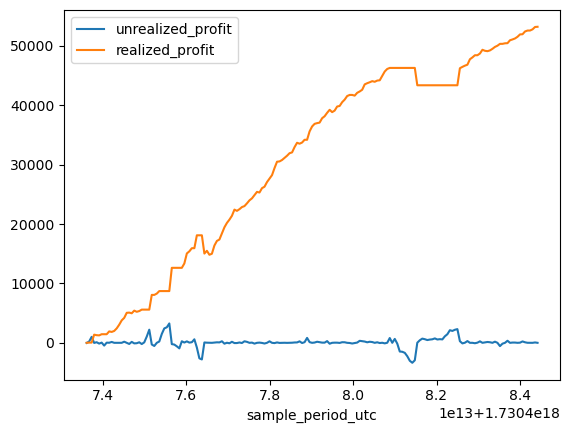

In [6]:
_ = df.loc[(0,'deribit','BTC-PERPETUAL')][['unrealized_profit','realized_profit']].plot()

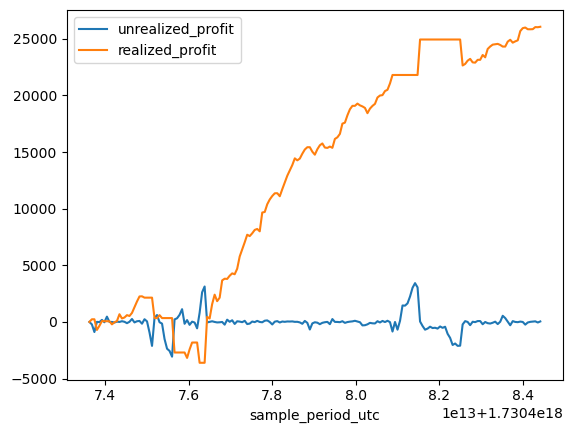

In [7]:
_ = df.loc[(1,'bybit','BTCUSD')][['unrealized_profit','realized_profit']].plot()